In [1]:
from IPython import display
import math
import pandas as pd
import numpy as np

from pyspark.sql import SQLContext
from pyspark import SparkContext

from pyspark.sql.types import *

In [2]:
sc =SparkContext( )
sqlContext = SQLContext(sc)

21/12/09 16:14:27 WARN Utils: Your hostname, pop-os resolves to a loopback address: 127.0.1.1; using 192.168.1.21 instead (on interface enp61s0)
21/12/09 16:14:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/09 16:14:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/home/codevardhan/dev/mental_health_analysis/env/lib/python3.9/site-packages/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
customSchema = StructType([
    StructField("clean_text", StringType()), 
    StructField("category", StringType())])

In [6]:
filename1 = './data/tweets.csv'
filename2 = './data/reddit.csv'

In [7]:
df1 = sqlContext.read.format("csv").option("header", "true").schema(customSchema).load(filename1)
df1.count()

4175

In [8]:
df2 = sqlContext.read.format("csv").option("header", "true").schema(customSchema).load(filename2)
df2.count()

989

In [9]:
df = df1.union(df2)
df.count() 

5164

In [10]:
data = df.na.drop(how='any')
data.show(5)

+----------+--------------------+
|clean_text|            category|
+----------+--------------------+
|         0|                none|
|         1|worry others focu...|
|         2|denial anger barg...|
|         3|really went etern...|
|         4|2021 chez moi tra...|
+----------+--------------------+
only showing top 5 rows



21/12/09 16:15:11 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/tweets.csv


In [11]:
data.printSchema()

root
 |-- clean_text: string (nullable = true)
 |-- category: string (nullable = true)



In [12]:
from pyspark.sql.functions import col

data.groupBy("category").count().orderBy(col("count").desc()).show()

21/12/09 16:15:16 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/reddit.csv
21/12/09 16:15:16 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/tweets.csv


+--------------------+-----+
|            category|count|
+--------------------+-----+
|                none|  143|
|          depression|   29|
|                  -1|    7|
|                   1|    7|
|                   "|    6|
|please help sign ...|    4|
|     depression real|    4|
|post concert depr...|    4|
|someone suffered ...|    3|
|     depression joke|    3|
|  smiling depression|    2|
|post concert depr...|    2|
|make sure take ca...|    2|
|spiritual awakeni...|    2|
|someone suffered ...|    2|
|read carefully pl...|    2|
|tropical depressi...|    2|
|denial anger barg...|    2|
|      visit exciting|    2|
| seasonal depression|    2|
+--------------------+-----+
only showing top 20 rows



*Model Pipeline*

In [13]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression

# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="clean_text", outputCol="words", pattern="\\W")

# stop words
add_stopwords = ["http","https","amp","rt","t","c","the"] 

stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=20000, minDF=5)

In [14]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
label_stringIdx = StringIndexer(inputCol = "category", outputCol = "label")

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
dataset.show(5)

21/12/09 16:15:21 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/tweets.csv
21/12/09 16:15:21 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/reddit.csv
21/12/09 16:15:21 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/reddit.csv
21/12/09 16:15:21 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/tweets.csv


+----------+--------------------+-----+--------+----------+------+
|clean_text|            category|words|filtered|  features| label|
+----------+--------------------+-----+--------+----------+------+
|         0|                none|  [0]|     [0]|(39,[],[])|   0.0|
|         1|worry others focu...|  [1]|     [1]|(39,[],[])|4669.0|
|         2|denial anger barg...|  [2]|     [2]|(39,[],[])|1364.0|
|         3|really went etern...|  [3]|     [3]|(39,[],[])|3600.0|
|         4|2021 chez moi tra...|  [4]|     [4]|(39,[],[])| 664.0|
+----------+--------------------+-----+--------+----------+------+
only showing top 5 rows



21/12/09 16:15:23 WARN DAGScheduler: Broadcasting large task binary with size 1111.3 KiB
21/12/09 16:15:23 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/tweets.csv


*Partition Training & Test sets & Model Training and Evaluation*

In [15]:
# set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

21/12/09 16:15:23 WARN DAGScheduler: Broadcasting large task binary with size 1127.6 KiB
21/12/09 16:15:23 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/tweets.csv
21/12/09 16:15:23 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/reddit.csv


Training Dataset Count: 3624
Test Dataset Count: 1527


21/12/09 16:15:24 WARN DAGScheduler: Broadcasting large task binary with size 1127.6 KiB
21/12/09 16:15:24 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/reddit.csv
21/12/09 16:15:24 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/tweets.csv


In [16]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0).select("clean_text","category","probability","label","prediction")\
.orderBy("probability", ascending=False).show(n = 10, truncate = 30)

21/12/09 16:15:24 WARN DAGScheduler: Broadcasting large task binary with size 1133.5 KiB
21/12/09 16:15:24 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/reddit.csv
21/12/09 16:15:24 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/tweets.csv
21/12/09 16:15:25 WARN DAGScheduler: Broadcasting large task binary with size 1135.1 KiB
21/12/09 16:15:25 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/reddit.csv
21/12/09 16:15:25 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Heade

+----------+------------------------------+------------------------------+------+----------+
|clean_text|                      category|                   probability| label|prediction|
+----------+------------------------------+------------------------------+------+----------+
|       101| bff who have known since 4...|[0.027181566113153158,0.016...| 161.0|       0.0|
|       102| hate being alive hate have...|[0.027181566113153158,0.016...| 320.0|       0.0|
|       110| boyfriend super excited ab...|[0.027181566113153158,0.016...| 164.0|       0.0|
|       111| feel like struggle articul...|[0.027181566113153158,0.016...| 264.0|       0.0|
|       114| won freedom and just becom...|[0.027181566113153158,0.016...| 616.0|       0.0|
|       116| year old male had horrible...|[0.027181566113153158,0.016...| 625.0|       0.0|
|       118| been trying for years find...|[0.027181566113153158,0.016...| 159.0|       0.0|
|       119| useless take space one nee...|[0.027181566113153158,0.016

In [17]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

21/12/09 16:15:45 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
21/12/09 16:15:45 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/tweets.csv
21/12/09 16:15:45 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/reddit.csv


0.0016466243572194424

Cross Validation


In [18]:
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

21/12/09 16:15:45 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/reddit.csv
21/12/09 16:15:45 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/tweets.csv
21/12/09 16:15:46 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/reddit.csv
21/12/09 16:15:46 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/tweets.csv


In [19]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
             #.addGrid(model.maxIter, [10, 20, 50]) #Number of iterations
             #.addGrid(idf.numFeatures, [10, 100, 1000]) # Number of features
             .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)

cvModel = cv.fit(trainingData)

predictions = cvModel.transform(testData)
# Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
lrAccuracy=evaluator.evaluate(predictions)

21/12/09 16:15:46 WARN DAGScheduler: Broadcasting large task binary with size 1150.9 KiB
21/12/09 16:15:46 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/tweets.csv
21/12/09 16:15:46 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/reddit.csv
21/12/09 16:15:46 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
21/12/09 16:15:47 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
21/12/09 16:15:47 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
21/12/09 16:15:48 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
21/12/09 16:15:48 WARN DAGScheduler: Broadcasting large task binary with size 1152.6 KiB
21

In [20]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1)
nbModel = nb.fit(trainingData)
predictions = nbModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

21/12/09 16:31:43 WARN DAGScheduler: Broadcasting large task binary with size 1137.2 KiB
21/12/09 16:31:43 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/tweets.csv
21/12/09 16:31:43 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/reddit.csv
21/12/09 16:31:44 WARN DAGScheduler: Broadcasting large task binary with size 1111.5 KiB
21/12/09 16:31:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
21/12/09 16:31:44 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/reddit.csv
21/12/09 16:31:44 WARN CSVHeaderChecker:

+------------------------------+------------------------------+------------------------------+------+----------+
|                    clean_text|                      category|                   probability| label|prediction|
+------------------------------+------------------------------+------------------------------+------+----------+
|’ getting ’ been depressed ...|                             1|[0.015048075712349701,0.003...|   3.0|       0.0|
|                           101| bff who have known since 4...|[0.015020546974635353,0.003...| 161.0|       0.0|
|                           110| boyfriend super excited ab...|[0.015020546974635353,0.003...| 164.0|       0.0|
|                           102| hate being alive hate have...|[0.015020546974635353,0.003...| 320.0|       0.0|
|                           118| been trying for years find...|[0.015020546974635353,0.003...| 159.0|       0.0|
|                           111| feel like struggle articul...|[0.015020546974635353,0.003...| 2

In [21]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
nbAccuracy = evaluator.evaluate(predictions)
print(nbAccuracy)

0.0012084920839165523


21/12/09 16:31:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
21/12/09 16:31:44 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/reddit.csv
21/12/09 16:31:44 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/tweets.csv


In [22]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(trainingData)
predictions = dtModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

21/12/09 16:31:45 WARN DAGScheduler: Broadcasting large task binary with size 1133.3 KiB
21/12/09 16:31:45 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/tweets.csv
21/12/09 16:31:45 WARN DAGScheduler: Broadcasting large task binary with size 1133.3 KiB
21/12/09 16:31:45 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/reddit.csv
21/12/09 16:31:45 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/tweets.csv
21/12/09 16:31:45 WARN DAGScheduler: Broadcasting large task binary with size 1138.7 KiB
21/12/09 16:31:45 WARN CSVHeaderCheck

+----------+------------------------------+------------------------------+------+----------+
|clean_text|                      category|                   probability| label|prediction|
+----------+------------------------------+------------------------------+------+----------+
|       101| bff who have known since 4...|[0.029061721561029614,0.005...| 161.0|       0.0|
|       102| hate being alive hate have...|[0.029061721561029614,0.005...| 320.0|       0.0|
|       110| boyfriend super excited ab...|[0.029061721561029614,0.005...| 164.0|       0.0|
|       111| feel like struggle articul...|[0.029061721561029614,0.005...| 264.0|       0.0|
|       114| won freedom and just becom...|[0.029061721561029614,0.005...| 616.0|       0.0|
|       116| year old male had horrible...|[0.029061721561029614,0.005...| 625.0|       0.0|
|       118| been trying for years find...|[0.029061721561029614,0.005...| 159.0|       0.0|
|       119| useless take space one nee...|[0.029061721561029614,0.005

In [23]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
dtAccuracy = evaluator.evaluate(predictions)
print(dtAccuracy) 

21/12/09 16:31:47 WARN DAGScheduler: Broadcasting large task binary with size 1496.1 KiB
21/12/09 16:31:47 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/tweets.csv
21/12/09 16:31:47 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/reddit.csv


0.0025205708262793407


In [24]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)
# Train model with Training Data
rfModel = rf.fit(trainingData)
predictions = rfModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

21/12/09 16:31:47 WARN DAGScheduler: Broadcasting large task binary with size 1133.3 KiB
21/12/09 16:31:47 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/tweets.csv
21/12/09 16:31:48 WARN DAGScheduler: Broadcasting large task binary with size 1133.3 KiB
21/12/09 16:31:48 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/reddit.csv
21/12/09 16:31:48 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/tweets.csv
21/12/09 16:31:48 WARN DAGScheduler: Broadcasting large task binary with size 1138.7 KiB
21/12/09 16:31:48 WARN CSVHeaderCheck

+----------+------------------------------+------------------------------+------+----------+
|clean_text|                      category|                   probability| label|prediction|
+----------+------------------------------+------------------------------+------+----------+
|       101| bff who have known since 4...|[0.02914470592562311,0.0057...| 161.0|       0.0|
|       102| hate being alive hate have...|[0.02914470592562311,0.0057...| 320.0|       0.0|
|       110| boyfriend super excited ab...|[0.02914470592562311,0.0057...| 164.0|       0.0|
|       111| feel like struggle articul...|[0.02914470592562311,0.0057...| 264.0|       0.0|
|       114| won freedom and just becom...|[0.02914470592562311,0.0057...| 616.0|       0.0|
|       116| year old male had horrible...|[0.02914470592562311,0.0057...| 625.0|       0.0|
|       118| been trying for years find...|[0.02914470592562311,0.0057...| 159.0|       0.0|
|       119| useless take space one nee...|[0.02914470592562311,0.0057

In [25]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
rfAccuracy = evaluator.evaluate(predictions)
print(rfAccuracy) 

21/12/09 16:32:10 WARN DAGScheduler: Broadcasting large task binary with size 32.4 MiB
21/12/09 16:32:10 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/tweets.csv
21/12/09 16:32:10 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/reddit.csv


0.0015382525551594977


In [26]:
from pyspark.ml.classification import LogisticRegression, OneVsRest
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)


ovr = OneVsRest(classifier=lr)

ovrModel = ovr.fit(trainingData)

# score the model on test data.
predictions = ovrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","label","prediction") \
    .show(n = 10, truncate = 30)


21/12/09 16:32:18 WARN DAGScheduler: Broadcasting large task binary with size 1128.9 KiB
21/12/09 16:32:18 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/reddit.csv
21/12/09 16:32:18 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/tweets.csv
21/12/09 16:32:19 WARN DAGScheduler: Broadcasting large task binary with size 1134.7 KiB
21/12/09 16:32:19 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 3, schema size: 2
CSV file: file:///home/codevardhan/dev/mental_health_analysis/data/tweets.csv
21/12/09 16:32:19 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Heade

Py4JJavaError: An error occurred while calling o93816.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 5764.0 failed 1 times, most recent failure: Lost task 1.0 in stage 5764.0 (TID 11489) (192.168.1.21 executor driver): org.apache.spark.SparkException: Failed to execute user defined function (StringIndexerModel$$Lambda$3906/0x0000000101666840: (string) => double)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:136)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$3(RDD.scala:1230)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$5(RDD.scala:1231)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Unseen label: 0. To handle unseen labels, set Param handleInvalid to keep.
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1(StringIndexer.scala:406)
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1$adapted(StringIndexer.scala:391)
	... 32 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2352)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2351)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2351)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1109)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2591)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2533)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2522)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:898)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2309)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1183)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1177)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1222)
	at org.apache.spark.ml.stat.Summarizer$.getClassificationSummarizers(Summarizer.scala:233)
	at org.apache.spark.ml.classification.LogisticRegression.$anonfun$train$1(LogisticRegression.scala:511)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:495)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:286)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:151)
	at jdk.internal.reflect.GeneratedMethodAccessor276.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function (StringIndexerModel$$Lambda$3906/0x0000000101666840: (string) => double)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:136)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$3(RDD.scala:1230)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$5(RDD.scala:1231)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: org.apache.spark.SparkException: Unseen label: 0. To handle unseen labels, set Param handleInvalid to keep.
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1(StringIndexer.scala:406)
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1$adapted(StringIndexer.scala:391)
	... 32 more


In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
ovrAccuracy = evaluator.evaluate(predictions)
print(ovrAccuracy)

0.7278688038734377


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
model = ['Logistic regression', 'Naive Bayes', 'Random Forest', 'OneVsRest']
accuracy = [lrAccuracy,nbAccuracy,rfAccuracy, ovrAccuracy]

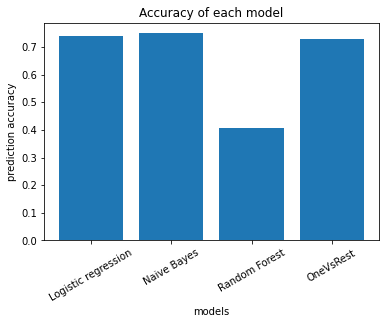

In [ ]:
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(model))
    plt.bar(index, accuracy)
    plt.xlabel('models', fontsize=10)
    plt.ylabel('prediction accuracy', fontsize=10)
    plt.xticks(index, model, fontsize=10, rotation=30)
    plt.title('Accuracy of each model')
    plt.show()
    
plot_bar_x()